In [1]:
import copy
import re
import pandas as pd
import numpy as np
from experiments import ExperimentModule
from experiments import (
    save_plots, 
    write_row, 
    write_opcounts,
    save_circuit,
    create_dir,
    get_random_state
)
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime

%matplotlib inline

In [2]:
datetime_str = str(datetime.now())
datetime_list = re.findall(r"\d+", datetime_str)
datetime_digits = "".join(datetime_list)

results_dir = f"results/{datetime_digits}"
create_dir(results_dir)

# Creating subdirectories
create_dir(f"{results_dir}/plots")
create_dir(f"{results_dir}/csv")
create_dir(f"{results_dir}/op_counts")
create_dir(f"{results_dir}/circuits")

In [3]:
qubit_range = [3, 4, 5, 6, 7, 8]
eps_values = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [4]:

for num_qubits, eps in product(qubit_range, eps_values):

    print("--"*50)
    print(f"\t\t Experiments for {num_qubits} qubits and {eps} error")
    print("--"*50)


    state = get_random_state(num_qubits)

    ansatz = SanchezAnsatz(state, eps)

    ## Running original
    print("--"*50)
    print("\t\t Running ORIGINAL Method")
    print("--"*50)
    init_params = ansatz.init_params
    t_ansatz = transpile(ansatz, basis_gates=["cx", "u"])

    em_original = ExperimentModule(
                    t_ansatz,
                    SPSA(maxiter=1000),
                    target_state=state,
                    init_params=init_params
                )

    result_original = em_original.minimize()

    ## Running modified
    print("--"*50)
    print("\t\t Running MODIFIED method")
    print("--"*50)
    ansatz = SanchezAnsatz(state, eps, build_modified=True)

    init_params = ansatz.init_params
    t_ansatz = transpile(ansatz, basis_gates=["cx", "u"])

    em_modified = ExperimentModule(
                    t_ansatz,
                    SPSA(maxiter=1000),
                    target_state=state,
                    init_params=init_params
                )

    result_modified = em_modified.minimize()

    # Saving comparison plots
    save_plots(em_original, em_modified, f"{results_dir}/plots/plot_{num_qubits}qb_{eps}eps.pdf")

    # writing csv loss progression
    write_row(em_original._loss_progression, file=f"{results_dir}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv")
    write_row(em_modified._loss_progression, file=f"{results_dir}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv")

    # writing csv best point
    write_row(em_original.result.x, file=f"{results_dir}/csv/original_xbest_{num_qubits}qb_{eps}eps.csv")
    write_row(em_modified.result.x, file=f"{results_dir}/csv/modified_xbest_{num_qubits}qb_{eps}eps.csv")

    # writing op_counts
    write_opcounts(em_original, em_modified, file=f"{results_dir}/op_counts/counts_{num_qubits}qb_{eps}eps.txt")

    # saving circuits
    save_circuit(em_original._ansatz, file=f"{results_dir}/circuits/original_curcuit_{num_qubits}qb_{eps}eps.pkl")
    save_circuit(em_modified._ansatz, file=f"{results_dir}/circuits/modified_curcuit_{num_qubits}qb_{eps}eps.pkl")

----------------------------------------------------------------------------------------------------
		 Experiments for 3 qubits and 0.5 error
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
		 Running ORIGINAL Method
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
		 Running MODIFIED method
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
		 Experiments for 3 qubits and 0.1 error
----------------------------------------------------------------------------------------------------
------------------------------------------------------

Creating pandas dataframe

Creating result dictionaries

In [5]:
#[0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
original_results_dict = {
    "num_qubits": [],
    0.5: [],
    0.1: [],
    0.05: [],
    0.01: [],
    0.005: [],
    0.001: []
}

modified_results_dict = copy.deepcopy(original_results_dict)

for num_qubits in qubit_range:
    original_results_dict["num_qubits"] += [num_qubits]
    modified_results_dict["num_qubits"] += [num_qubits]

    for eps in eps_values:
        fid_loss_original = np.loadtxt(f"{results_dir}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
        data_original = fid_loss_original[-1][-1] if len(fid_loss_original.shape) > 1 else fid_loss_original[-1]
        original_results_dict[eps]+= [round(data_original,4)]

        fid_loss_modified = np.loadtxt(f"{results_dir}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
        data_modified = fid_loss_modified[-1][-1] if len(fid_loss_modified.shape) > 1 else fid_loss_modified[-1]
        modified_results_dict[eps]+= [round(data_modified, 4)]

Original fidloss

In [6]:
df_original = pd.DataFrame(original_results_dict)
df_original=df_original.set_index("num_qubits")
df_original

,0.5,0.1,0.05,0.01,0.005,0.001
num_qubits,,,,,,
3,0.1595,0.1595,0.1530,0.1530,0.1530,0.1530
4,0.1600,0.1600,0.1580,0.0653,0.0653,0.0653
5,0.1909,0.1909,0.1904,0.1881,0.1881,0.1594
6,0.2219,0.2219,0.2180,0.2150,0.1970,0.1637
7,0.2453,0.9998,0.2453,0.2376,0.2248,0.3062
8,0.9941,0.9984,0.2424,0.2397,0.2290,0.3403


Modified fidloss

In [7]:
df_modified = pd.DataFrame(modified_results_dict)
df_modified = df_modified.set_index("num_qubits")
df_modified

,0.5,0.1,0.05,0.01,0.005,0.001
num_qubits,,,,,,
3,0.4043,0.4043,0.4525,0.4525,0.4525,0.4525
4,0.4371,0.4371,0.6462,0.3537,0.3537,0.3537
5,0.5481,0.5481,0.5861,0.6917,0.6917,0.5236
6,0.6022,0.6022,0.6980,0.8361,0.7538,0.5108
7,0.5855,0.5855,0.7972,0.8962,0.8760,0.7400
8,0.5980,0.5980,0.8231,0.9112,0.9405,0.8765


In [8]:
abs(df_original -df_modified)/(df_original + df_modified)

,0.5,0.1,0.05,0.01,0.005,0.001
num_qubits,,,,,,
3,0.434197,0.434197,0.494633,0.494633,0.494633,0.494633
4,0.464076,0.464076,0.607063,0.688305,0.688305,0.688305
5,0.483356,0.483356,0.509594,0.572403,0.572403,0.533236
6,0.461473,0.461473,0.524017,0.590905,0.585612,0.514603
7,0.409485,0.261339,0.529400,0.580878,0.591570,0.414643
8,0.248791,0.250814,0.545002,0.583456,0.608380,0.440664


Counting depth

In [9]:
depth_count_original = []
depth_count_modified = []

for qb_idx, num_qubits in enumerate(qubit_range):
    depth_count_original += [[]]
    depth_count_modified += [[]]

    for eps in eps_values:
        #circuit = load_circuit(f"results/circuits/curcuit_{num_qubits}qb_{eps}eps.pkl")
        state = get_random_state(num_qubits)

        # original
        ansatz = SanchezAnsatz(state, eps)
        to_ansatz = transpile(ansatz, basis_gates=["cx", "u"])
        depth_count_original[qb_idx] += [to_ansatz.depth()]

        # modified
        mod_ansatz = SanchezAnsatz(state, eps, build_modified=True)
        tm_ansatz = transpile(mod_ansatz, basis_gates=["cx", "u"])
        depth_count_modified[qb_idx] += [tm_ansatz.depth()]


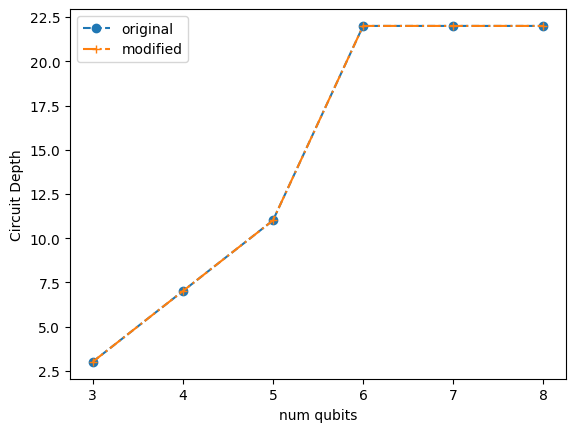

In [10]:
mean_depth_original = np.mean(depth_count_original, axis=1, dtype=np.int32)
mean_depth_modified = np.mean(depth_count_modified, axis=1, dtype=np.int32)

plt.plot(qubit_range, mean_depth_original, "--", marker="o", label='original')
plt.plot(qubit_range, mean_depth_modified, "-.", marker="+", label="modified")
plt.xlabel("num qubits")
plt.ylabel("Circuit Depth")
plt.legend(loc="best")
plt.plot()
plt.savefig("results/mean_circuit_depth.pdf")